In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import xarray as xr
import pandas as pd

from glob import glob
from os.path import join
from scipy import interpolate

import itertools
import datetime
import time
import sys  
import re

sys.path.insert(0, '../')

from soundings.deep_learning import mlutilities as ml
from soundings.deep_learning import tf_neuralnetwork as nn
from soundings.deep_learning import goes_neuralnetwork as goesnn

from soundings.plotting import radiosonde_plotting
from soundings.utils import radiosonde_products, radiosonde_utils

from IPython.display import display
from ipywidgets import FloatProgress

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
processed_vol = '/mnt/data1/stock/mlsoundings/processed/'
PLOT_CMAP = 'RdYlBu_r'

PRESSURE = 0
TEMPERATURE = 1
DEWPOINT = 2
ALTITUDE = 3

gpus = tf.config.get_visible_devices('GPU')
for device in gpus:
    print(device)
#     tf.config.experimental.set_visible_devices(device, 'GPU')
    tf.config.experimental.set_memory_growth(device, True)
print()
!nvidia-smi

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')

Tue Sep  1 15:24:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     Off  | 00000000:3D:00.0 Off |                  Off |
| 33%   42C    P2    66W / 260W |    912MiB / 24220MiB |     23%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 6000     Off  | 00000000:B2:00.0 Off |                  Off |
| 33%   31C    P8     6W / 260W |    

# Evaluation Functions

In [3]:
def plot_altitude_rmse(nnet, X, T, NWP_Temp, file_name=None):
    """
    Plot the RMSE over different altitudes for some NeuralNetwork architecture.

    :params
    ---
    nnet : class
        Trained Neural Network class that will be used for evaluation
    X : np.array
        Input to the trained nnet
    T : np.array
        Targets to compare to for the nnet. Will often be the temperature profile from the RAOB.
    NWP_Temp : np.array
        Temperature profile from the NWP mode. Should have the same shape T.
    """
    default_font = 12
    figure_width = 12
    figure_height = 4
    line_width = 2
    
    if file_name:
        default_font = 14
        figure_width = 12
        figure_height = 4
        line_width = 2.5
        
    def plot_rmse(rmse, mean_rmse, color, label):
            axs[0].plot(alt, rmse, color=color, linewidth=line_width)
            axs[0].hlines(mean_rmse, alt[0], alt[-1], label=f'{label} {mean_rmse:.3f}',
                          color=color, linestyle='--', linewidth=line_width)

            axs[1].plot(alt[:surface_error], rmse[:surface_error], color=color, linewidth=line_width)
            axs[1].hlines(mean_rmse, alt[:surface_error][0], alt[:surface_error][-1],
                          color=color, linestyle='--', linewidth=line_width)
            
    alt = raob[0, :, ALTITUDE]
    surface_error = 100
    
    fig, axs = plt.subplots(1, 2, figsize=(figure_width, figure_height))
    axs = axs.ravel()
    
    rap_rmse = np.sqrt((np.mean((NWP_Temp - T)**2, axis=0)))
    rap_mean_rmse = ml.rmse(NWP_Temp, T)
    plot_rmse(rap_rmse, rap_mean_rmse, 
              radiosonde_plotting.colour_from_numpy_to_tuple(
                  radiosonde_plotting.DEFAULT_OPTION_DICT[radiosonde_plotting.NWP_LINE_COLOUR_KEY]), 
              'NWP')
    
    Y = nnet.use(X)
    ml_rmse = np.sqrt((np.mean((Y - T)**2, axis=0)))
    ml_mean_rmse = ml.rmse(Y, T)
    plot_rmse(ml_rmse, ml_mean_rmse,
              radiosonde_plotting.colour_from_numpy_to_tuple(
                  radiosonde_plotting.DEFAULT_OPTION_DICT[radiosonde_plotting.PREDICTED_LINE_COLOUR_KEY]),
              'ML')

    axs[0].set_xlabel('Altitude (m)', fontsize=default_font)
    axs[1].set_xlabel('Altitude (m)', fontsize=default_font)
    axs[0].set_ylabel('RMSE (C)', fontsize=default_font)
    axs[0].legend(fontsize=default_font);
    
    for ax in axs:
        ax.tick_params(axis='x', labelsize=default_font)
        ax.tick_params(axis='y', labelsize=default_font)
        ax.grid(True)
    
    if file_name:
        plt.savefig(file_name, dpi=300)
        plt.show()
        plt.close()
    
    
def plot_loss(nnet):
    fig, ax = plt.subplots(1, figsize=(8, 4))

    ax.plot(nnet.history['loss'], label='train')
    ax.plot(nnet.history['val_loss'], label='val')
    ax.legend();

# RAP

## Data Loader

In [4]:
xar = xr.open_dataset(sorted(glob(join(processed_vol, '*')))[0])
xar

<xarray.Dataset>
Dimensions:         (band: 8, goes_x: 28, goes_y: 28, nwp_dims: 50, profile_dims: 2048, rtma_type: 3, rtma_x: 28, rtma_y: 28)
Coordinates:
  * goes_y          (goes_y) int64 0 1 2 3 4 5 6 7 8 ... 20 21 22 23 24 25 26 27
  * goes_x          (goes_x) int64 0 1 2 3 4 5 6 7 8 ... 20 21 22 23 24 25 26 27
  * band            (band) int64 8 9 10 11 13 14 15 16
  * rtma_y          (rtma_y) int64 0 1 2 3 4 5 6 7 8 ... 20 21 22 23 24 25 26 27
  * rtma_x          (rtma_x) int64 0 1 2 3 4 5 6 7 8 ... 20 21 22 23 24 25 26 27
  * rtma_type       (rtma_type) object 'LPI' 'LRI' 'LTI'
  * profile_dims    (profile_dims) int64 0 1 2 3 4 ... 2043 2044 2045 2046 2047
  * nwp_dims        (nwp_dims) int64 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49
Data variables:
    sonde_rel_time  datetime64[ns] ...
    sonde_file      object ...
    sonde_pres      (profile_dims) float64 ...
    sonde_tdry      (profile_dims) float64 ...
    sonde_dp        (profile_dims) float64 ...
    sonde_alt       (profile_dims) float64 ...
    nwp_file        object ...
    nwp_lon         object ...
    nwp_lat         object ...
    nwp_pres        (nwp_dims) float64 ...
    nwp_tdry        (nwp_dims) float64 ...
    nwp_spfm        (nwp_dims) float64 ...
    nwp_alt         (nwp_dims) float64 ...
    goes_files      (band) object ...
    goes_abi        (band, goes_y, goes_x) float32 ...
    goes_lon        (goes_y, goes_x) float64 ...
    goes_lat        (goes_y, goes_x) float64 ...
    rtma_files      (rtma_type) object ...
    rtma_values     (rtma_type, rtma_y, rtma_x) float32 ...
    rtma_lon        (rtma_y, rtma_x) float64 ...
    rtma_lat        (rtma_y, rtma_x) float64 ...

In [4]:
# TODO: Should this be done in preprocessing?

def interpolate_to_height_intervals(alt, y, altitude_intervals):
    f = interpolate.interp1d(alt, y)
    return f(altitude_intervals)


def load_samples():
    files = sorted(glob(join(processed_vol, '*')))
    print(f'total of {len(files)} samples!')
    
    fp = FloatProgress(min=0, max=(len(files)))
    display(fp)
    
    sonde_files = []
    raob = []
    rap = []
    goes = []
    rtma = []
    
    s = time.time()
    for i, f in enumerate(files):
        xar = xr.open_dataset(f)
        raob_profile = np.concatenate((xar.sonde_pres.values.reshape(-1,1),
                                       xar.sonde_tdry.values.reshape(-1,1),
                                       xar.sonde_dp.values.reshape(-1,1),
                                       xar.sonde_alt.values.reshape(-1,1)), axis=1)
        raob.append(raob_profile)
        
        alt = xar.nwp_alt.values
        altitude_intervals = np.linspace(alt[0], 18_000, 256)
        
        pres = interpolate_to_height_intervals(alt, xar.nwp_pres.values/100., altitude_intervals)
        tdry = interpolate_to_height_intervals(alt, xar.nwp_tdry.values-272.15, altitude_intervals)
        spfm = interpolate_to_height_intervals(alt, xar.nwp_spfm.values, altitude_intervals)
        
        rap_profile = np.concatenate((pres.reshape(-1,1),
                                      tdry.reshape(-1,1),
                                      spfm.reshape(-1,1),
                                      altitude_intervals.reshape(-1,1)), axis=1)
        rap.append(rap_profile)
        goes.append(xar.goes_abi.values)
        rtma.append(xar.rtma_values.values)
        sonde_files.append(str(xar.sonde_file.values))
        xar.close()
        fp.value += 1

    e = time.time() - s
    print(f'time: {e:.3f}, avg: {e/len(files):.3f} seconds')
    
    return (np.array(raob), np.array(rap), np.array(goes).transpose(0, 2, 3, 1),
            np.array(rtma).transpose(0, 2, 3, 1), sonde_files)

raob, rap, goes, rtma, sonde_files = load_samples()

print(raob.shape, rap.shape, goes.shape, rtma.shape)

total of 330 samples!


FloatProgress(value=0.0, max=330.0)

time: 9.128, avg: 0.028 seconds
(330, 256, 4) (330, 256, 4) (330, 3, 3, 8) (330, 3, 3, 3)


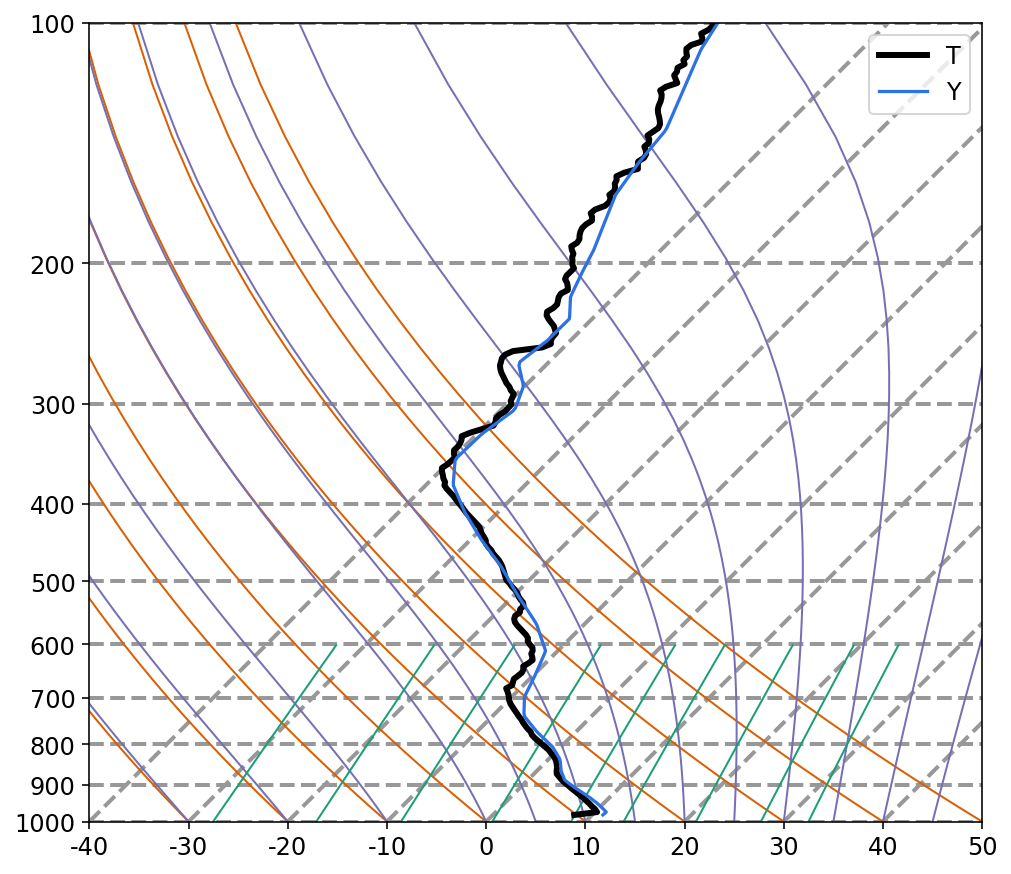

In [8]:
index = 11
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = raob[index,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = raob[index,:,TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = rap[index,:,TEMPERATURE]

radiosonde_plotting.plot_predicted_sounding(sounding);

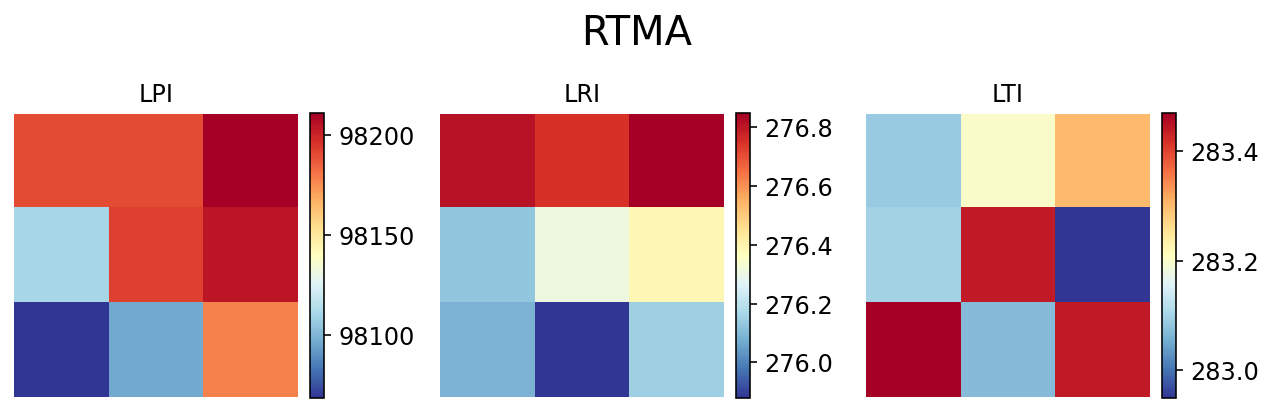

In [9]:
rtma_type = ['LPI', 'LRI', 'LTI']

fig, axs = plt.subplots(1, 3, figsize=(9,3))
[axi.set_axis_off() for axi in axs.ravel()]
for i in range(3):
    c = axs[i].imshow(rtma[index,:,:,i], cmap=PLOT_CMAP)
    fig.colorbar(c, ax=axs[i], fraction=0.046, pad=0.04)
    axs[i].set_title(f'{str(rtma_type[i])}')
fig.suptitle('RTMA', fontsize=20)
fig.tight_layout()

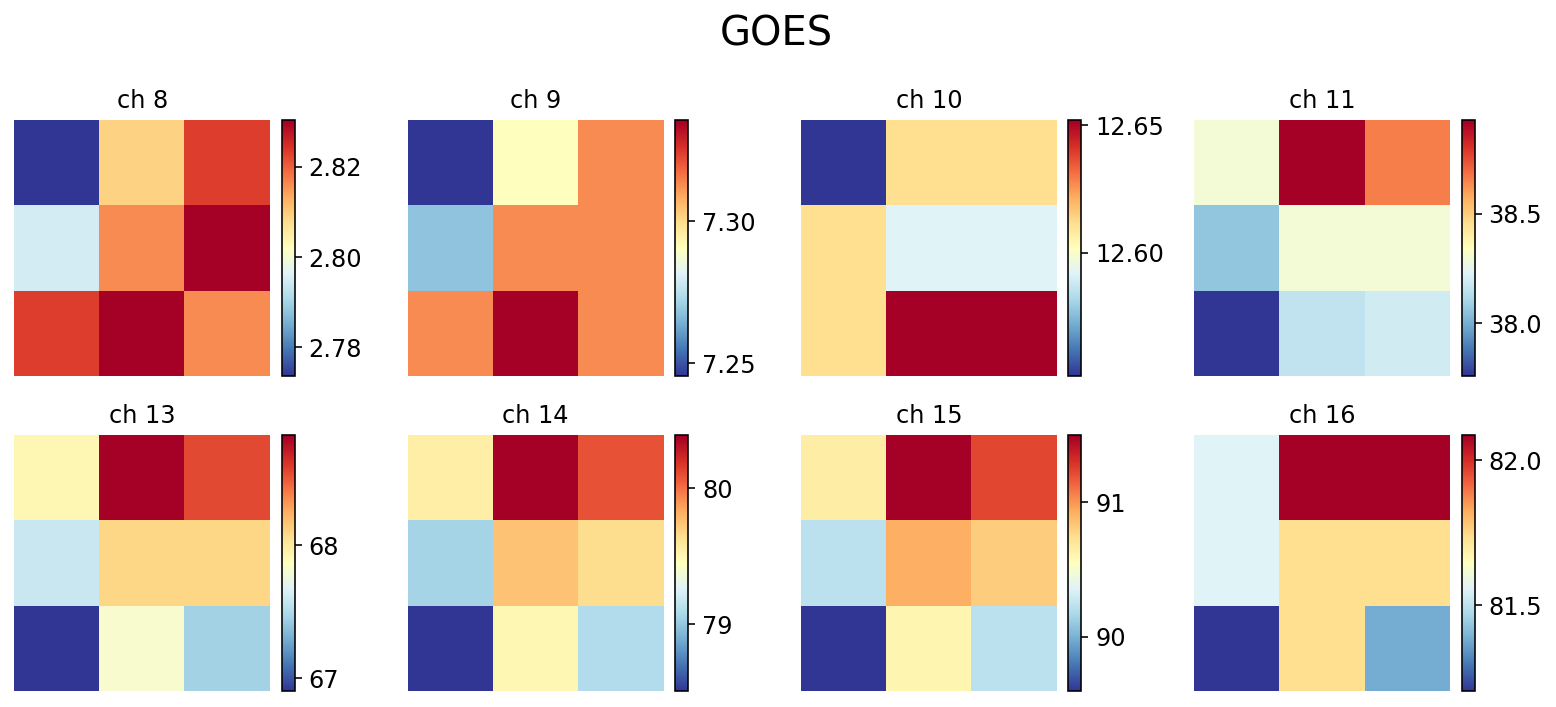

In [10]:
bands = [8, 9, 10, 11, 13, 14, 15, 16]

# vmin = goes[index,:,:,:].min()
# vmax = goes[index,:,:,:].max()

fig, axs = plt.subplots(2, 4, figsize=(11,5))
[axi.set_axis_off() for axi in axs.ravel()]
r = 0
for i in range(8):
    if i >= 4: r = 1
    c = axs[r, i % 4].imshow(goes[index,:,:,i], cmap=PLOT_CMAP) # vmin=vmin, vmax=vmax,
    cbar = fig.colorbar(c, ax=axs[r, i % 4], fraction=0.046, pad=0.04)
    cbar.ax.locator_params(nbins=3)
    axs[r, i % 4].set_title(f'ch {str(bands[i])}')
plt.suptitle('GOES', fontsize=20)
fig.tight_layout()

## Linear NN

In [11]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=False)

input_dims = [PRESSURE, TEMPERATURE]
Xt = Xtrain[:,:,input_dims].reshape(Xtrain.shape[0],-1)
Tt = Ttrain[:,:,[TEMPERATURE]].reshape(Ttrain.shape[0],-1)
Xe = Xtest[:,:,input_dims].reshape(Xtest.shape[0],-1)
Te = Ttest[:,:,[TEMPERATURE]].reshape(Ttest.shape[0],-1)

Xt.shape, Tt.shape, Xe.shape, Te.shape

((264, 512), (264, 256), (66, 512), (66, 256))

In [15]:
nnet = nn.NeuralNetwork(Xt.shape[1], [0], Tt.shape[1], activation='tanh', seed=1234)

nnet.model.summary()

nnet.train(Xt, Tt, 50, 32, method='adam', verbose=True, 
           learning_rate=0.001, validation=[Xe, Te])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
Total params: 131,328
Trainable params: 131,328
Non-trainable params: 0
_________________________________________________________________
epoch: 0, loss: 1.04506
epoch: 5, loss: 0.11125
epoch: 10, loss: 0.07634
epoch: 15, loss: 0.06545
epoch: 20, loss: 0.06036
epoch: 25, loss: 0.05571
epoch: 30, loss: 0.05442
epoch: 35, loss: 0.05384
epoch: 40, loss: 0.05276
epoch: 45, loss: 0.05089
epoch: 49, loss: 0.05194
finished!


NeuralNetwork(512, [0], 256)
  Final objective value is 0.05194 in 1.8066 seconds.

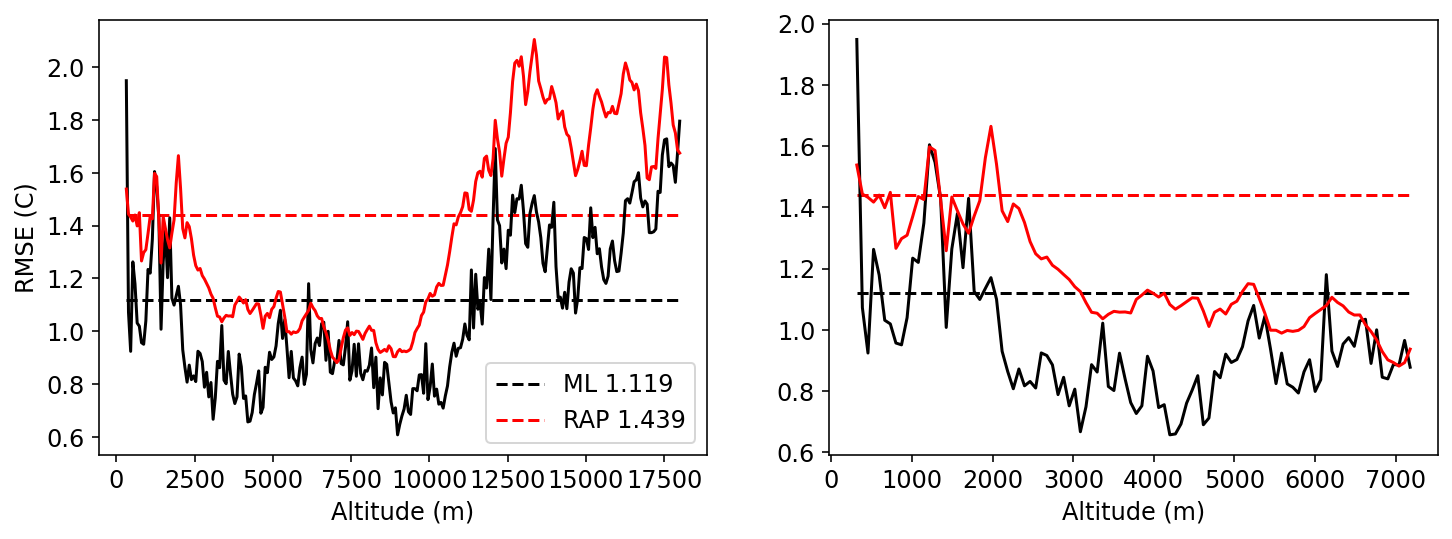

In [16]:
plot_altitude_rmse(nnet, Xe, Te, Xtest[:,:,TEMPERATURE])

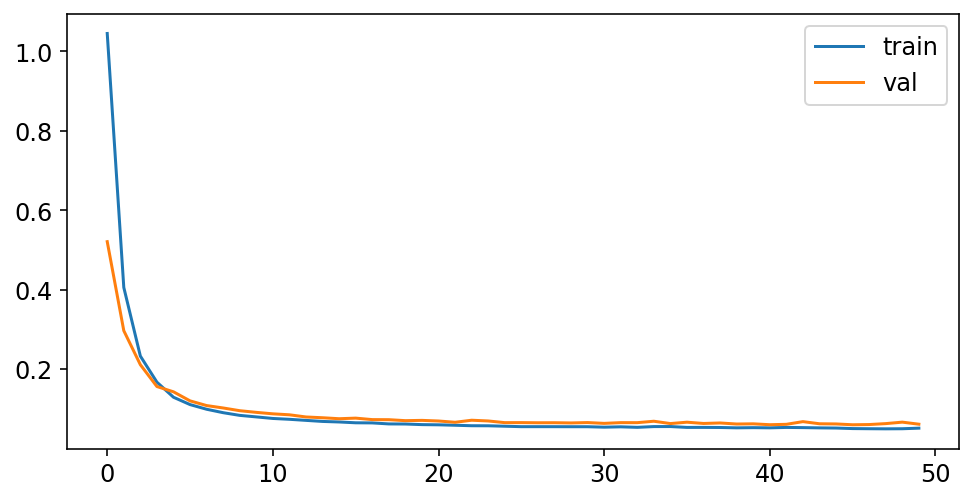

In [17]:
plot_loss(nnet)

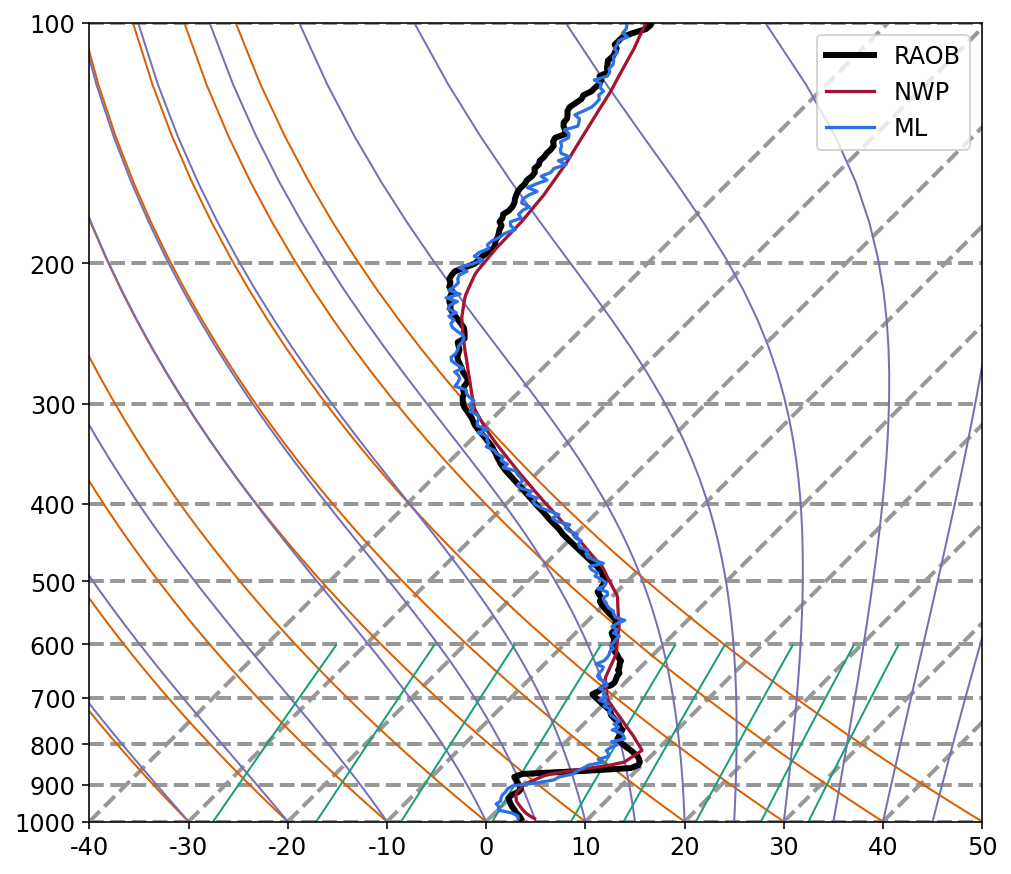

In [18]:
i = 1
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Te[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xe[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

## Fully Connected NN

In [19]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=False)

input_dims = [PRESSURE, TEMPERATURE]
Xt = Xtrain[:,:,input_dims].reshape(Xtrain.shape[0],-1)
Tt = Ttrain[:,:,[TEMPERATURE]].reshape(Ttrain.shape[0],-1)
Xe = Xtest[:,:,input_dims].reshape(Xtest.shape[0],-1)
Te = Ttest[:,:,[TEMPERATURE]].reshape(Ttest.shape[0],-1)

Xt.shape, Tt.shape, Xe.shape, Te.shape

((264, 512), (264, 256), (66, 512), (66, 256))

In [20]:
# https://github.com/tensorflow/tensorflow/issues/36465#issuecomment-631358715

layers = [[nu] * nl for nu in [4, 8, 16, 32, 64] for nl in range(1, 5)]

train_percentage = []
test_percentage = []

top = float('inf')
best_nnet = None

f = FloatProgress(min=0, max=len(layers))
display(f)
for layer in layers:
    nnet = nn.NeuralNetwork(Xt.shape[1], layer, Tt.shape[1], activation='tanh', seed=1234)

    nnet.train(Xt, Tt, 50, 16, method='adam', verbose=False, learning_rate=0.001)

    Y = nnet.use(Xt)
    train_percentage.append(ml.rmse(Tt, Y))

    Y = nnet.use(Xe)
    temp = ml.rmse(Te, Y)
    test_percentage.append(temp)

    if temp < top:
        best_nnet = nnet
        top = temp
        
    del nnet
    
    f.value += 1

FloatProgress(value=0.0, max=20.0)

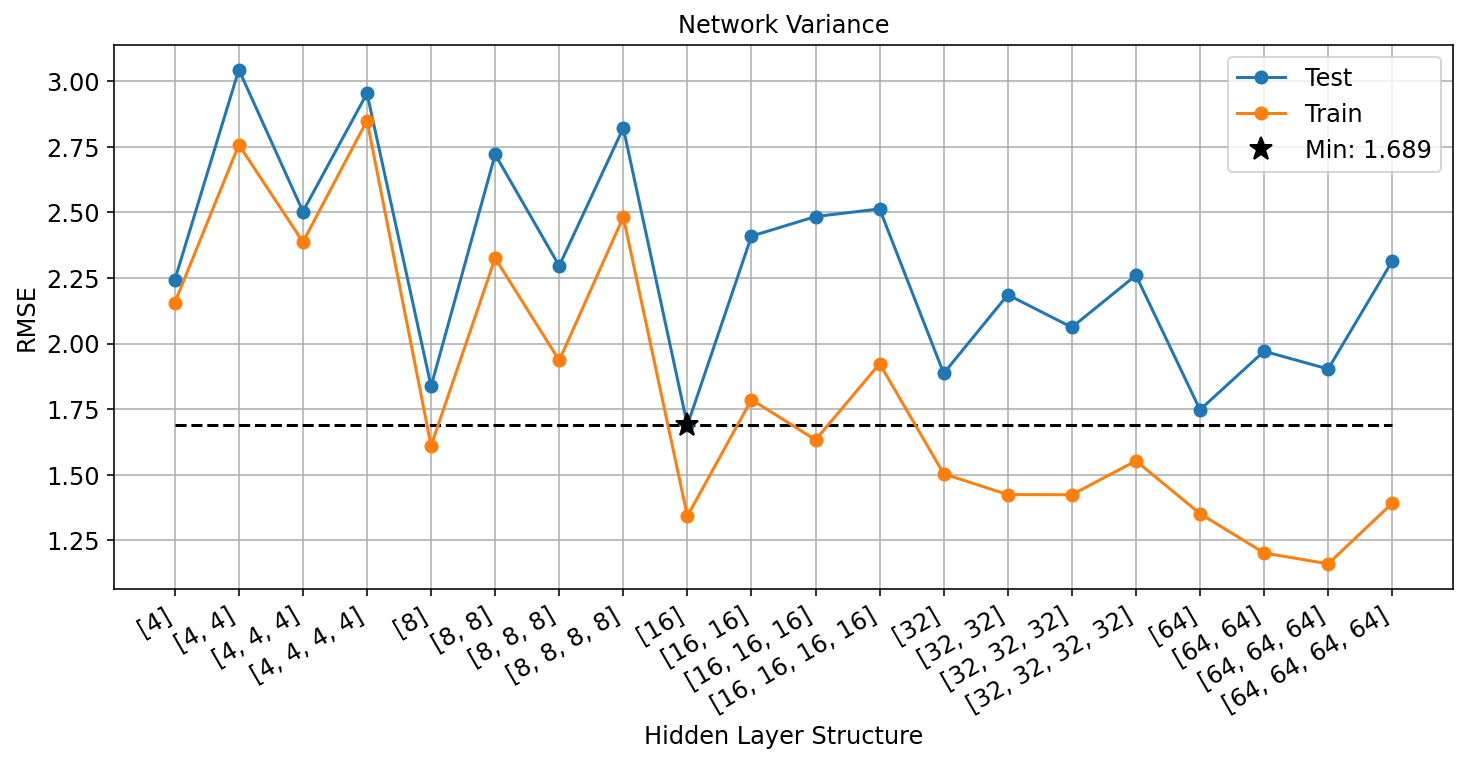

In [21]:
plt.figure(figsize=(12, 5))
plt.plot(test_percentage, 'o-')
plt.plot(train_percentage, 'o-')

top_index = np.argmin(test_percentage)
top = test_percentage[top_index]

plt.hlines(top, 0, len(layers) - 1, linestyle='dashed', color='black')
plt.plot(top_index, top, 'k*', markersize=12)
plt.xticks(range(len(layers)), layers, rotation=30, horizontalalignment='right')

plt.legend(('Test', 'Train', 'Min: {:.3f}'.format(top)))
plt.grid(True); plt.title('Network Variance')
plt.xlabel('Hidden Layer Structure'); plt.ylabel('RMSE');

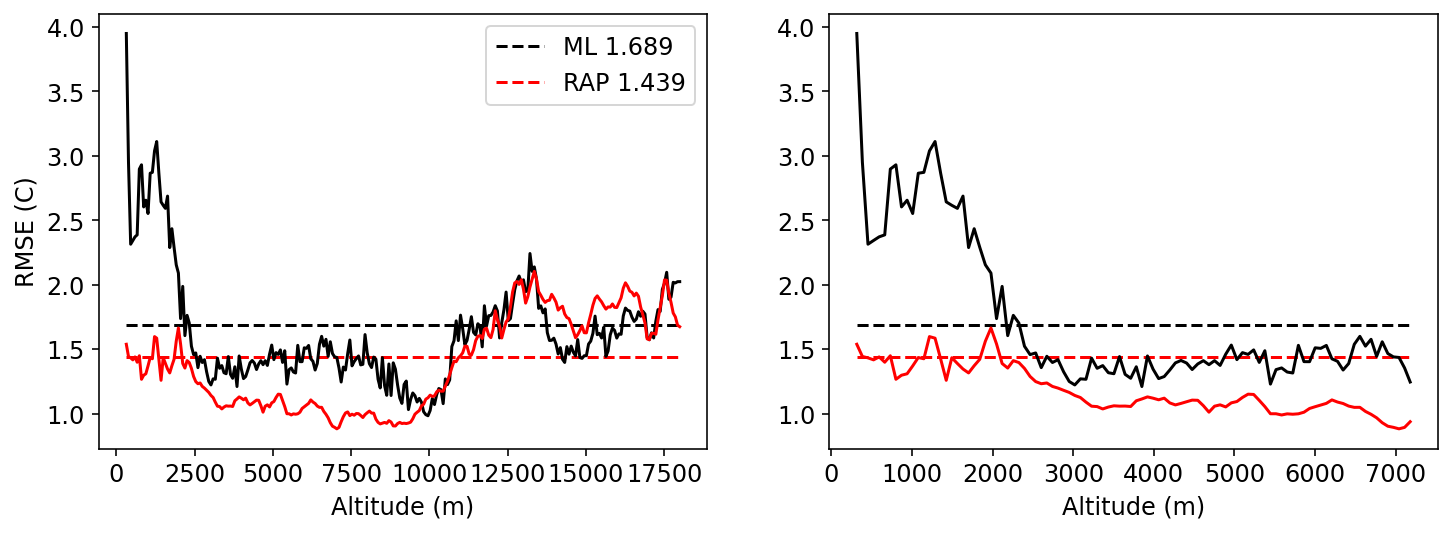

In [22]:
plot_altitude_rmse(best_nnet, Xe, Te, Xtest[:,:,TEMPERATURE])

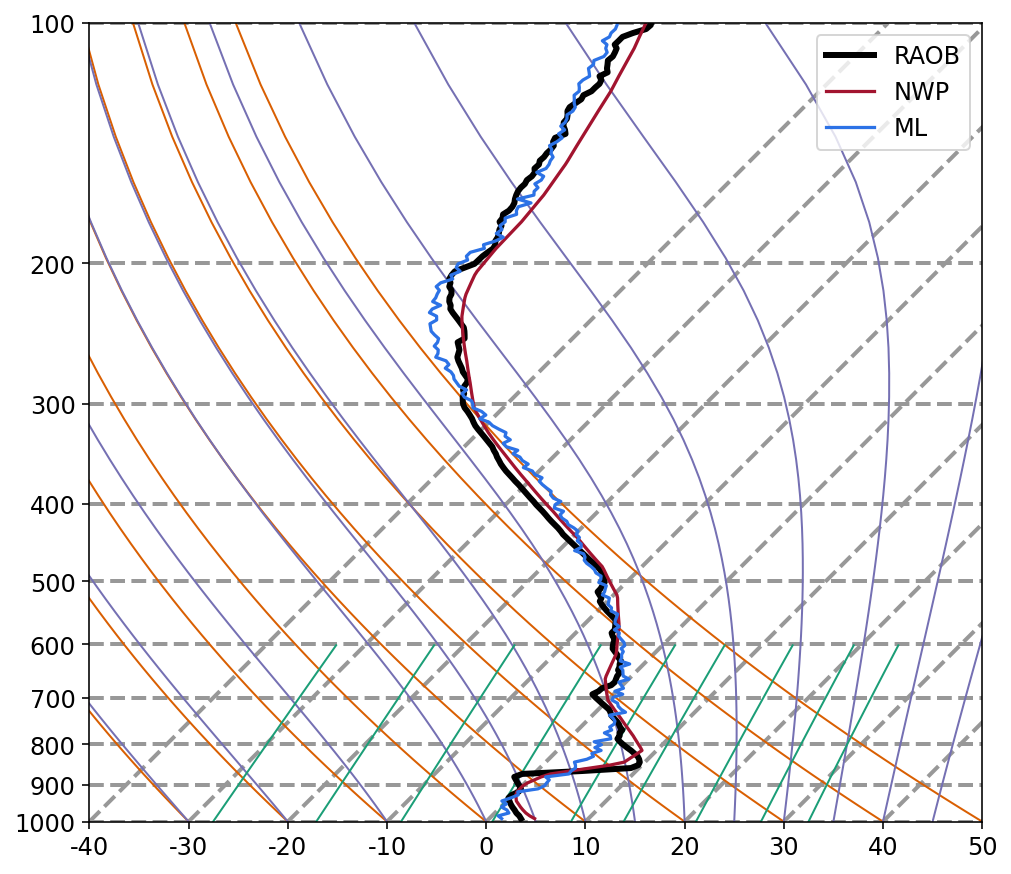

In [23]:
i = 1
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Te[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = best_nnet.use(Xe[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

## Conv1D NN

In [510]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=True)

input_dims = [PRESSURE, TEMPERATURE]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, TEMPERATURE]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, TEMPERATURE]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((264, 256, 2), (264, 256), (66, 256, 2), (66, 256))

In [511]:
# https://github.com/tensorflow/tensorflow/issues/36465#issuecomment-631358715

layers = [[128, 64, 32], [32, 64, 128]] + [[nu] * nl for nu in [8, 16, 32, 64, 128] for nl in range(1, 4)]

train_percentage = []
test_percentage = []

top = float('inf')
best_nnet = None

f = FloatProgress(min=0, max=len(layers))
display(f)
for layer in layers:
    nnet = nn.ConvolutionalNeuralNetwork(Xtrain.shape[1:], layer, [(10, 1)]*len(layer),
                                         Ttrain.shape[1], activation='tanh', seed=1234)
    nnet.train(Xtrain, Ttrain, 25, 32, method='adam', verbose=False, learning_rate=0.001)

    Y = nnet.use(Xtrain)
    train_percentage.append(ml.rmse(Ttrain, Y))

    Y = nnet.use(Xtest)
    temp = ml.rmse(Ttest, Y)
    test_percentage.append(temp)

    if temp < top:
        best_nnet = nnet
        top = temp
        
    del nnet
    
    f.value += 1

FloatProgress(value=0.0, max=17.0)

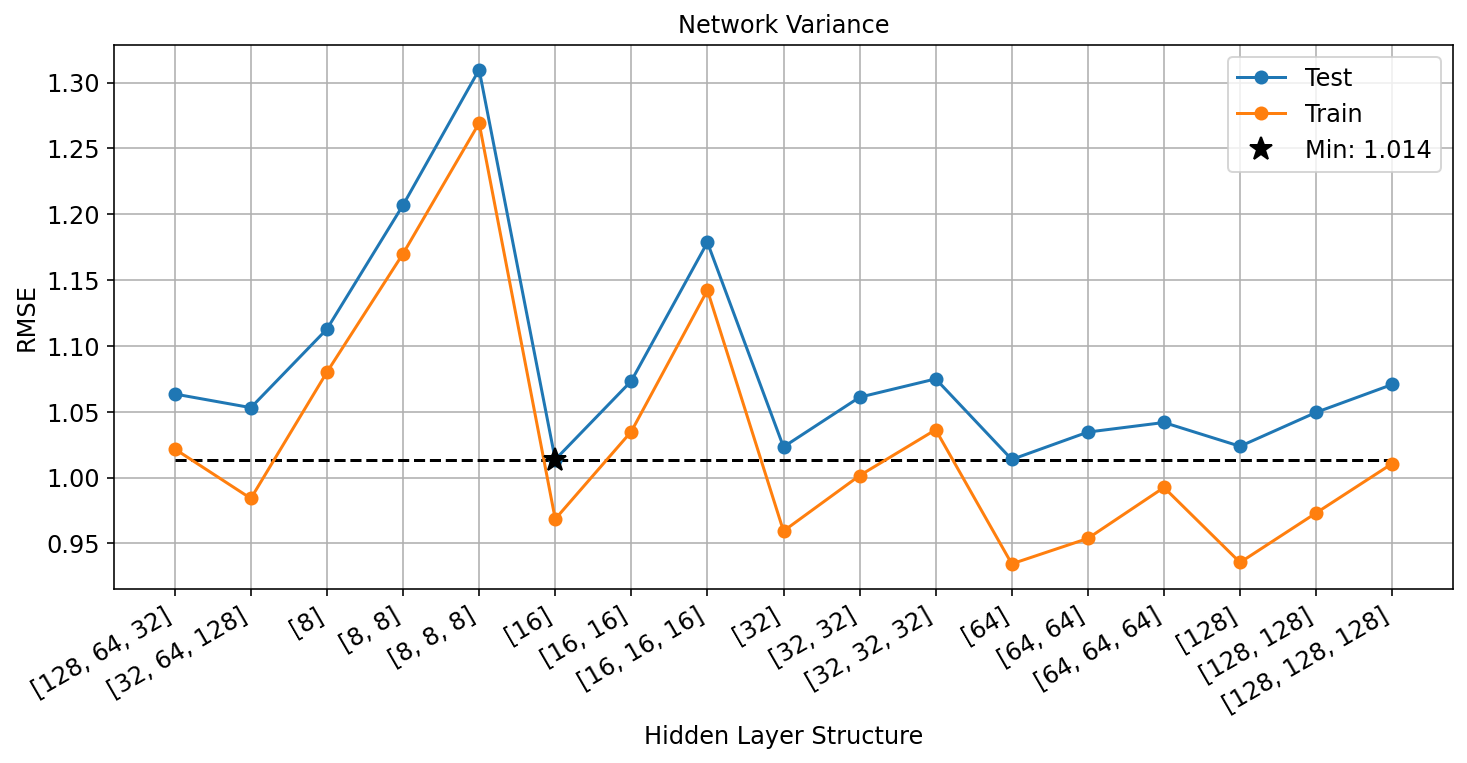

In [566]:
plt.figure(figsize=(12, 5))
plt.plot(test_percentage, 'o-')
plt.plot(train_percentage, 'o-')

top_index = np.argmin(test_percentage)
top = test_percentage[top_index]

plt.hlines(top, 0, len(layers) - 1, linestyle='dashed', color='black')
plt.plot(top_index, top, 'k*', markersize=12)
plt.xticks(range(len(layers)), layers, rotation=30, horizontalalignment='right')

plt.legend(('Test', 'Train', 'Min: {:.3f}'.format(top)))
plt.grid(True); plt.title('Network Variance')
plt.xlabel('Hidden Layer Structure'); plt.ylabel('RMSE');

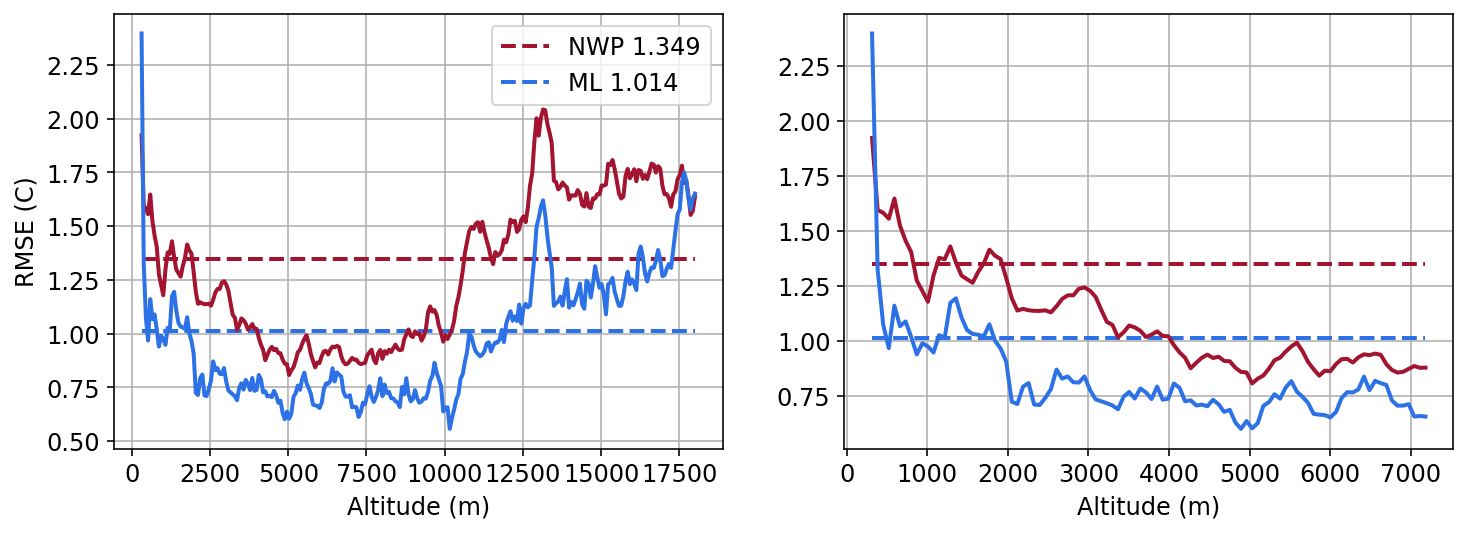

In [513]:
plot_altitude_rmse(best_nnet, Xtest, Ttest, Xtest[:,:,TEMPERATURE])

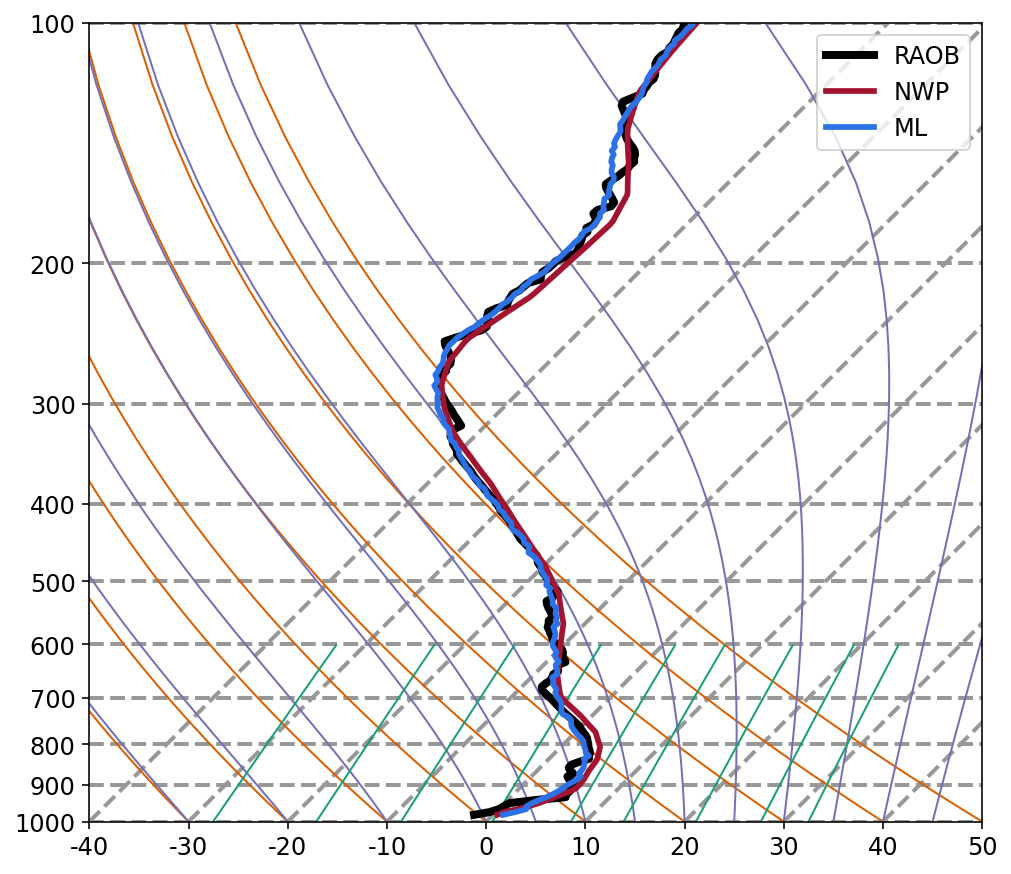

In [516]:
i = 15
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Ttest[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = best_nnet.use(Xtest[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

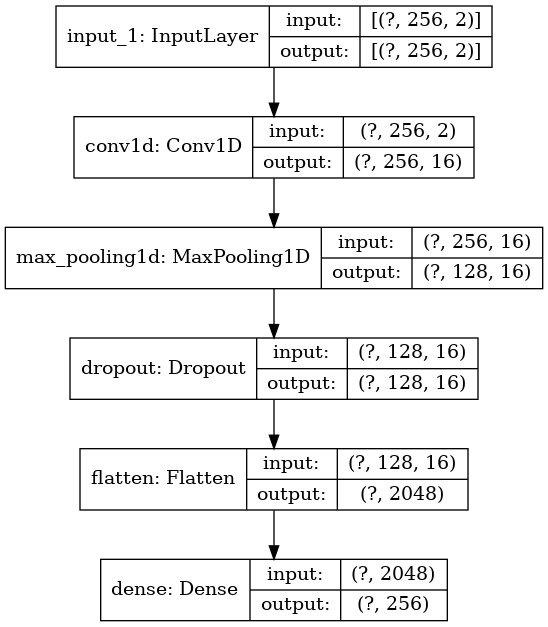

In [515]:
tf.keras.utils.plot_model(best_nnet.model, '/home/stock/research/media/rap_only_network.png',
                          show_shapes=True, rankdir='TB', dpi=96) # LR/TB positioning

## CAP CAE

In [578]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=True)

input_dims = [PRESSURE, TEMPERATURE]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, TEMPERATURE]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, TEMPERATURE]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((264, 256, 2), (264, 256), (66, 256, 2), (66, 256))

In [585]:
# https://github.com/tensorflow/tensorflow/issues/36465#issuecomment-631358715

layers = [[nu] * nl for nu in [4, 8, 16, 32] for nl in range(1, 4)]
hidden_dims = [32, 64, 128]
train_percentage = []
test_percentage = []

top = float('inf')
best_nnet = None

product = list(itertools.product(hidden_dims, layers))

f = FloatProgress(min=0, max=len(product))
display(f)

for hidden_dims, layer in product:
    nnet = nn.ConvolutionalAutoEncoder(Xtrain.shape[1:], layer, [(10, 1)]*len(layer),
                                       Ttrain.shape[1], activation='tanh',
                                       n_hidden_dims=hidden_dims, seed=1234)
    nnet.train(Xtrain, Ttrain, 25, 32, method='adam', verbose=False, learning_rate=0.001)

    Y = nnet.use(Xtrain)
    train_percentage.append(ml.rmse(Ttrain, Y))

    Y = nnet.use(Xtest)
    temp = ml.rmse(Ttest, Y)
    test_percentage.append(temp)

    if temp < top:
        best_nnet = nnet
        top = temp
        
    del nnet
    
    f.value += 1

FloatProgress(value=0.0, max=36.0)

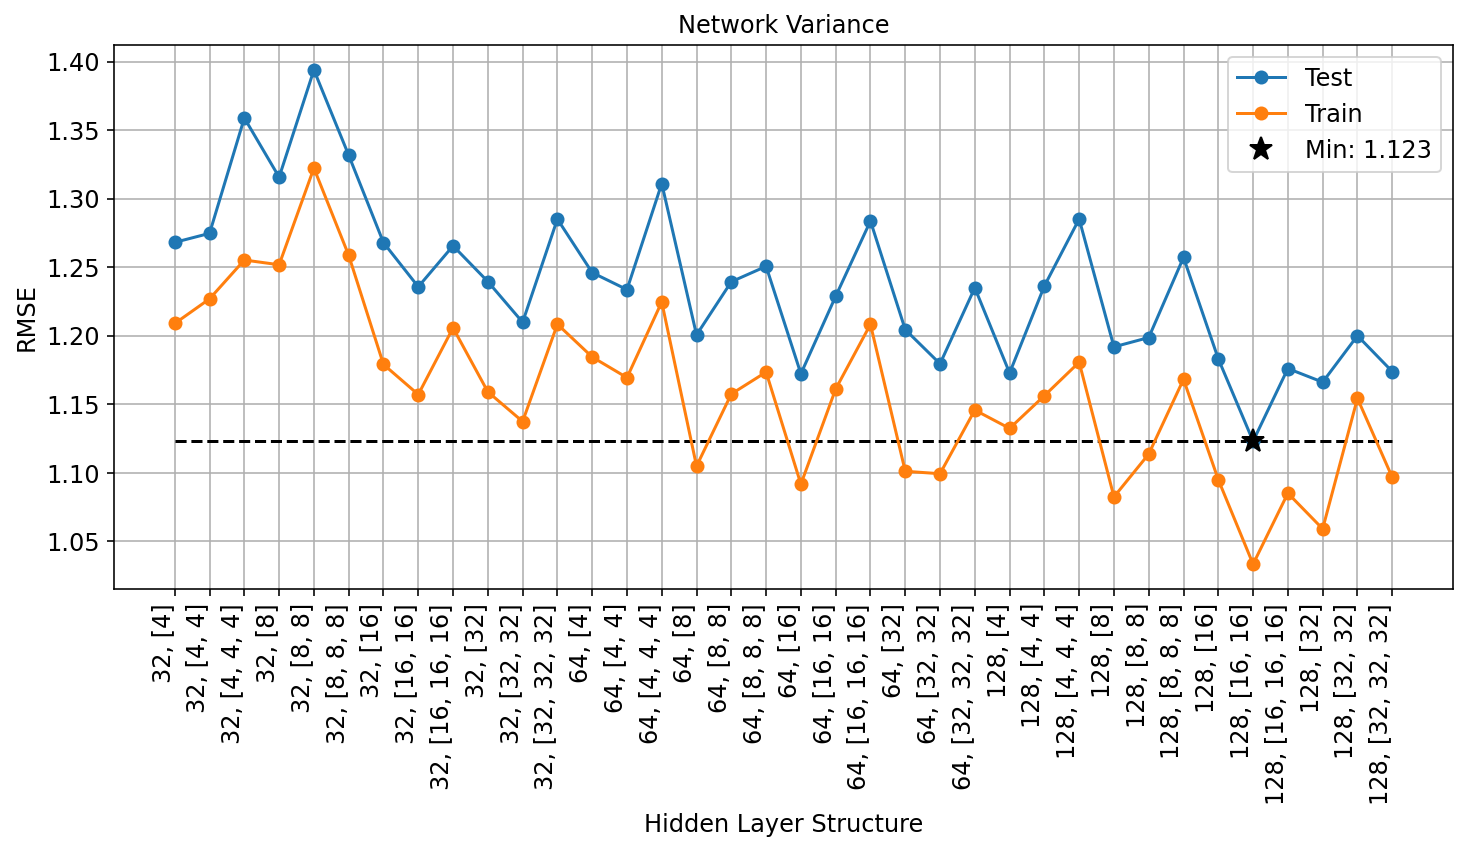

In [586]:
# 1.301 using ReLU
plt.figure(figsize=(12, 5))
plt.plot(test_percentage, 'o-')
plt.plot(train_percentage, 'o-')

top_index = np.argmin(test_percentage)
top = test_percentage[top_index]

plt.hlines(top, 0, len(product) - 1, linestyle='dashed', color='black')
plt.plot(top_index, top, 'k*', markersize=12)
plt.xticks(range(len(product)), [str(p)[1:-1] for p in product],
           rotation=90, horizontalalignment='right')

plt.legend(('Test', 'Train', 'Min: {:.3f}'.format(top)))
plt.grid(True); plt.title('Network Variance')
plt.xlabel('Hidden Layer Structure'); plt.ylabel('RMSE');

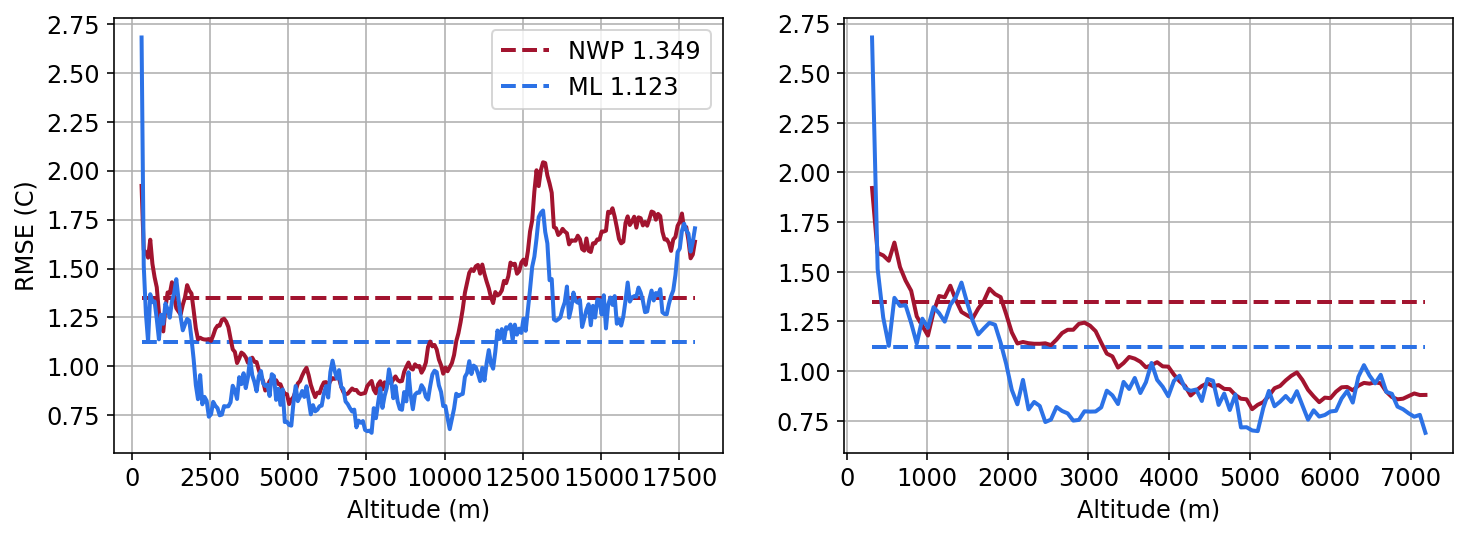

In [587]:
plot_altitude_rmse(best_nnet, Xtest, Ttest, Xtest[:,:,TEMPERATURE])
                   #file_name=f"/home/stock/research/media/raob_cae_rmse.png")

## Transfer Learning RAOB

Best performance is noticed when retraining over the entire model, or freezing the weights before the latent vector.

In [334]:
def insert_intermediate_layer(model, layer_regex, layer_factory):
    x = model.layers[0].output
    for layer in model.layers[1:]:
        x = layer(x)
        if re.match(layer_regex, layer.name):
            new_layer = layer_factory()
            new_layer._name = f'{layer.name}_{new_layer.name}'
            x = new_layer(x)
            print(f'Added {new_layer.name} after {layer.name}')
    return tf.keras.Model(model.layers[0].input, x)

In [335]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=True)

input_dims = [PRESSURE, TEMPERATURE]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, TEMPERATURE]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, TEMPERATURE]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((264, 256, 2), (264, 256), (66, 256, 2), (66, 256))

In [588]:
## 0.970 with raob_cae freeze before `dense` with 20, 32, 0.0001 'adam'
nnet = nn.loadnn('/mnt/data1/stock/mlsoundings/models/raob_cae')
# nnet = nn.loadnn('/mnt/data1/stock/mlsoundings/models/raob_noisy_cae')

def dropout_layer_factory():
    return tf.keras.layers.Dropout(rate=0.1, name='dropout')
def batchnorm_layer_factory():
    return tf.keras.layers.BatchNormalization(name='batch_norm')

# (?<![\w\d])dense(?![\w\d])
# nnet.model = insert_intermediate_layer(nnet.model, '(?<![\w\d])conv1d(?![\w\d])', batchnorm_layer_factory)
# nnet.model = insert_intermediate_layer(nnet.model, 'up_sampling1d', dropout_layer_factory)

for layer in nnet.model.layers:
    ## Freeze all except for ...
    # if layer.name != 'dense':
    #     layer.trainable = False
    if layer == nnet.model.get_layer('dense'):
        break
    layer.trainable = False
    
nnet.train(Xtrain, Ttrain, 20, 32, validation=[Xtest, Ttest], method='adam',
           learning_rate=0.0001, verbose=False)

ConvolutionalAutoEncoder((256, 2), [8, 8], [(10, 1), (10, 1)], 256)
  Final objective value is 0.03962 in 3.3753 seconds.

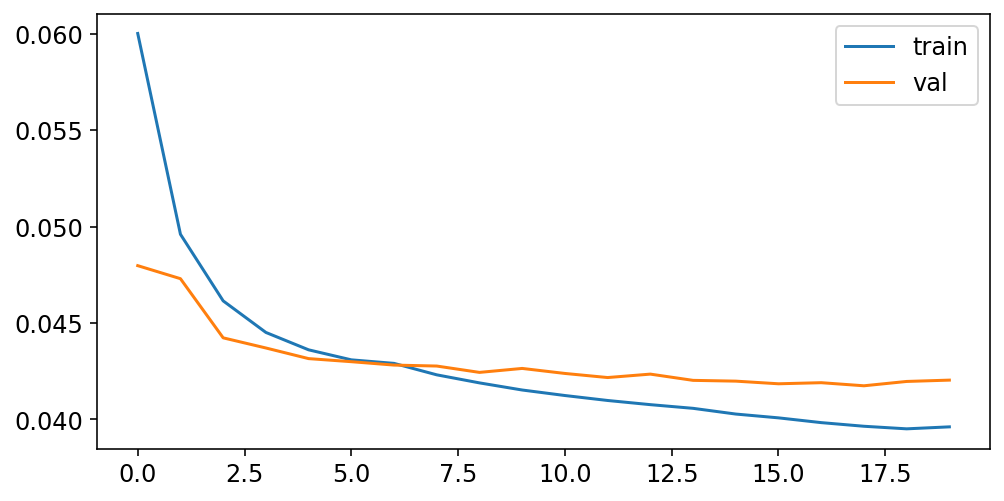

In [589]:
plot_loss(nnet)

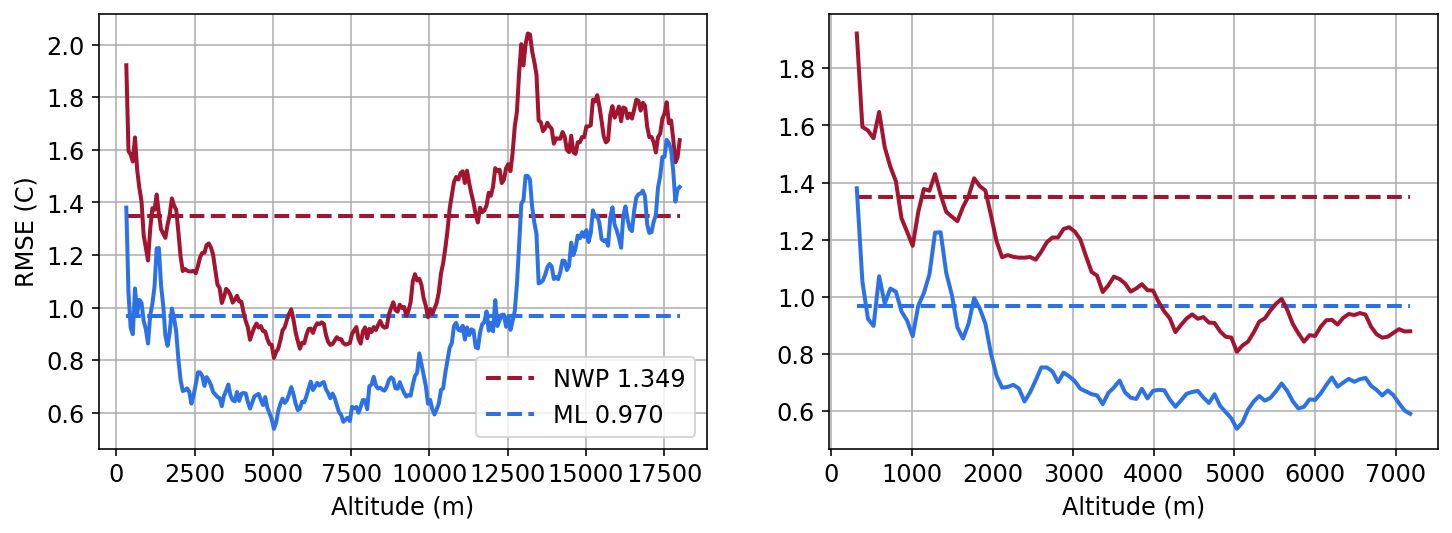

In [590]:
plot_altitude_rmse(nnet, Xtest, Ttest, Xtest[:,:,TEMPERATURE])
                   #file_name=f"/home/stock/research/media/transfer_learning_rmse.png")  

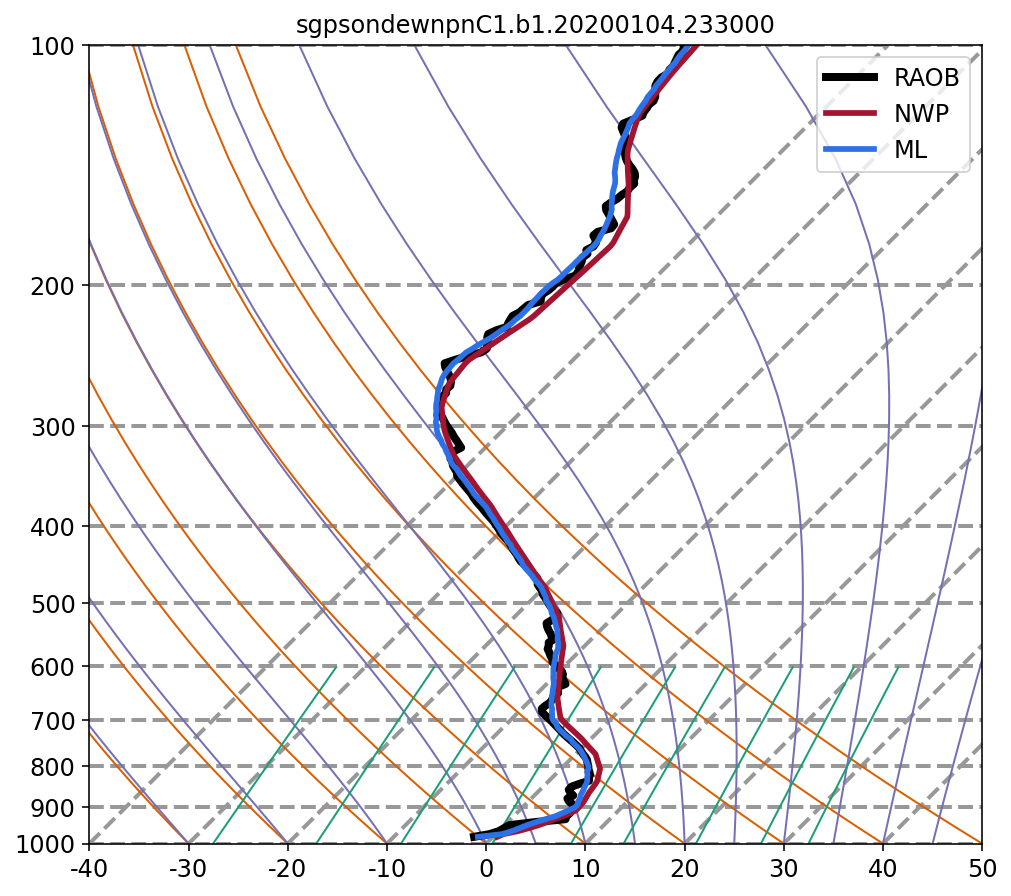

In [598]:
i = 15
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Ttest[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xtest[i:i+1,:])[0]

title = sonde_files[i].split('/')[-1][:-4]
radiosonde_plotting.plot_nwp_ml_sounding(sounding, title_string=title);
                                         #file_name=f"/home/stock/research/media/{title}.png");

## Weighted Loss

In [241]:
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import ops

In [242]:
def weighted_mean_squared_error(y_true, y_pred, scale, lmda):
    """exponential decay weighted MSE"""
    y_pred = ops.convert_to_tensor_v2(y_pred)
    y_true = math_ops.cast(y_true, y_pred.dtype)
    diff = math_ops.squared_difference(y_pred, y_true)

    x = np.arange(diff.shape[1])
    y = lambda x: scale * np.exp(-lmda * x) + 1
    diff *= y(x)

    return K.mean(diff, axis=-1)

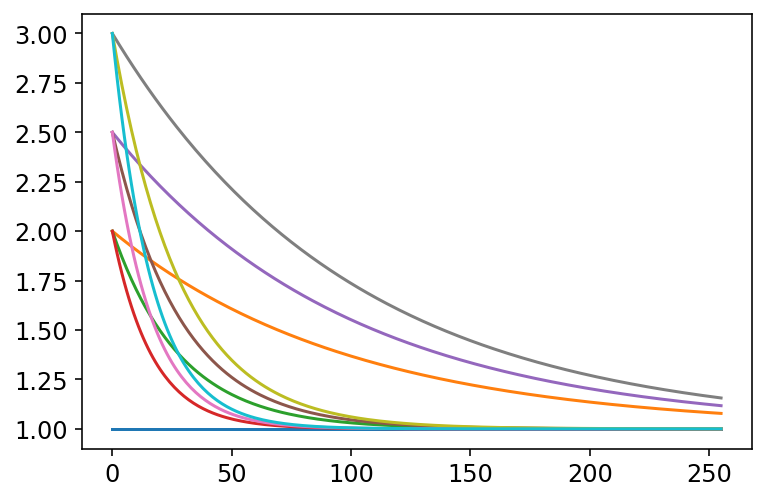

In [275]:
x = np.arange(Xtest.shape[1])

scales = np.linspace(1, 2, 3)
lmdas = np.linspace(0.01, 0.06, 3)

product = list(itertools.product(scales, lmdas))
product.insert(0, (0., 0.))

for scale, lmda in product:
    y = lambda x: scale * np.exp(-lmda * x) + 1
    plt.plot(y(x));

In [289]:
loss_l = []
rmse_l = []
total_rmse_l = []

f = FloatProgress(min=0, max=(len(product)))
display(f)

for scale, lmda in product:
    nnet = nn.ConvolutionalNeuralNetwork(Xtrain.shape[1:], [128], [(10, 1)]*len(layer),
                                             Ttrain.shape[1], activation='tanh', seed=1234)
    
    nnet.train(Xtrain, Ttrain, 20, 32, method='adam', verbose=False, learning_rate=0.001,
               validation=[Xtest, Ttest], loss_f=[lambda y_true,y_pred: 
                                                  weighted_mean_squared_error(y_true, y_pred, 
                                                                              scale=scale, lmda=lmda)])
    
    loss_l.append(nnet.history['val_loss'])
    
    Y = nnet.use(Xtest)
    rmse_l.append(np.sqrt((np.mean((Y - Ttest)**2, axis=0))))
    total_rmse_l.append(ml.rmse(Y, Ttest))
    
    f.value += 1

FloatProgress(value=0.0, max=10.0)

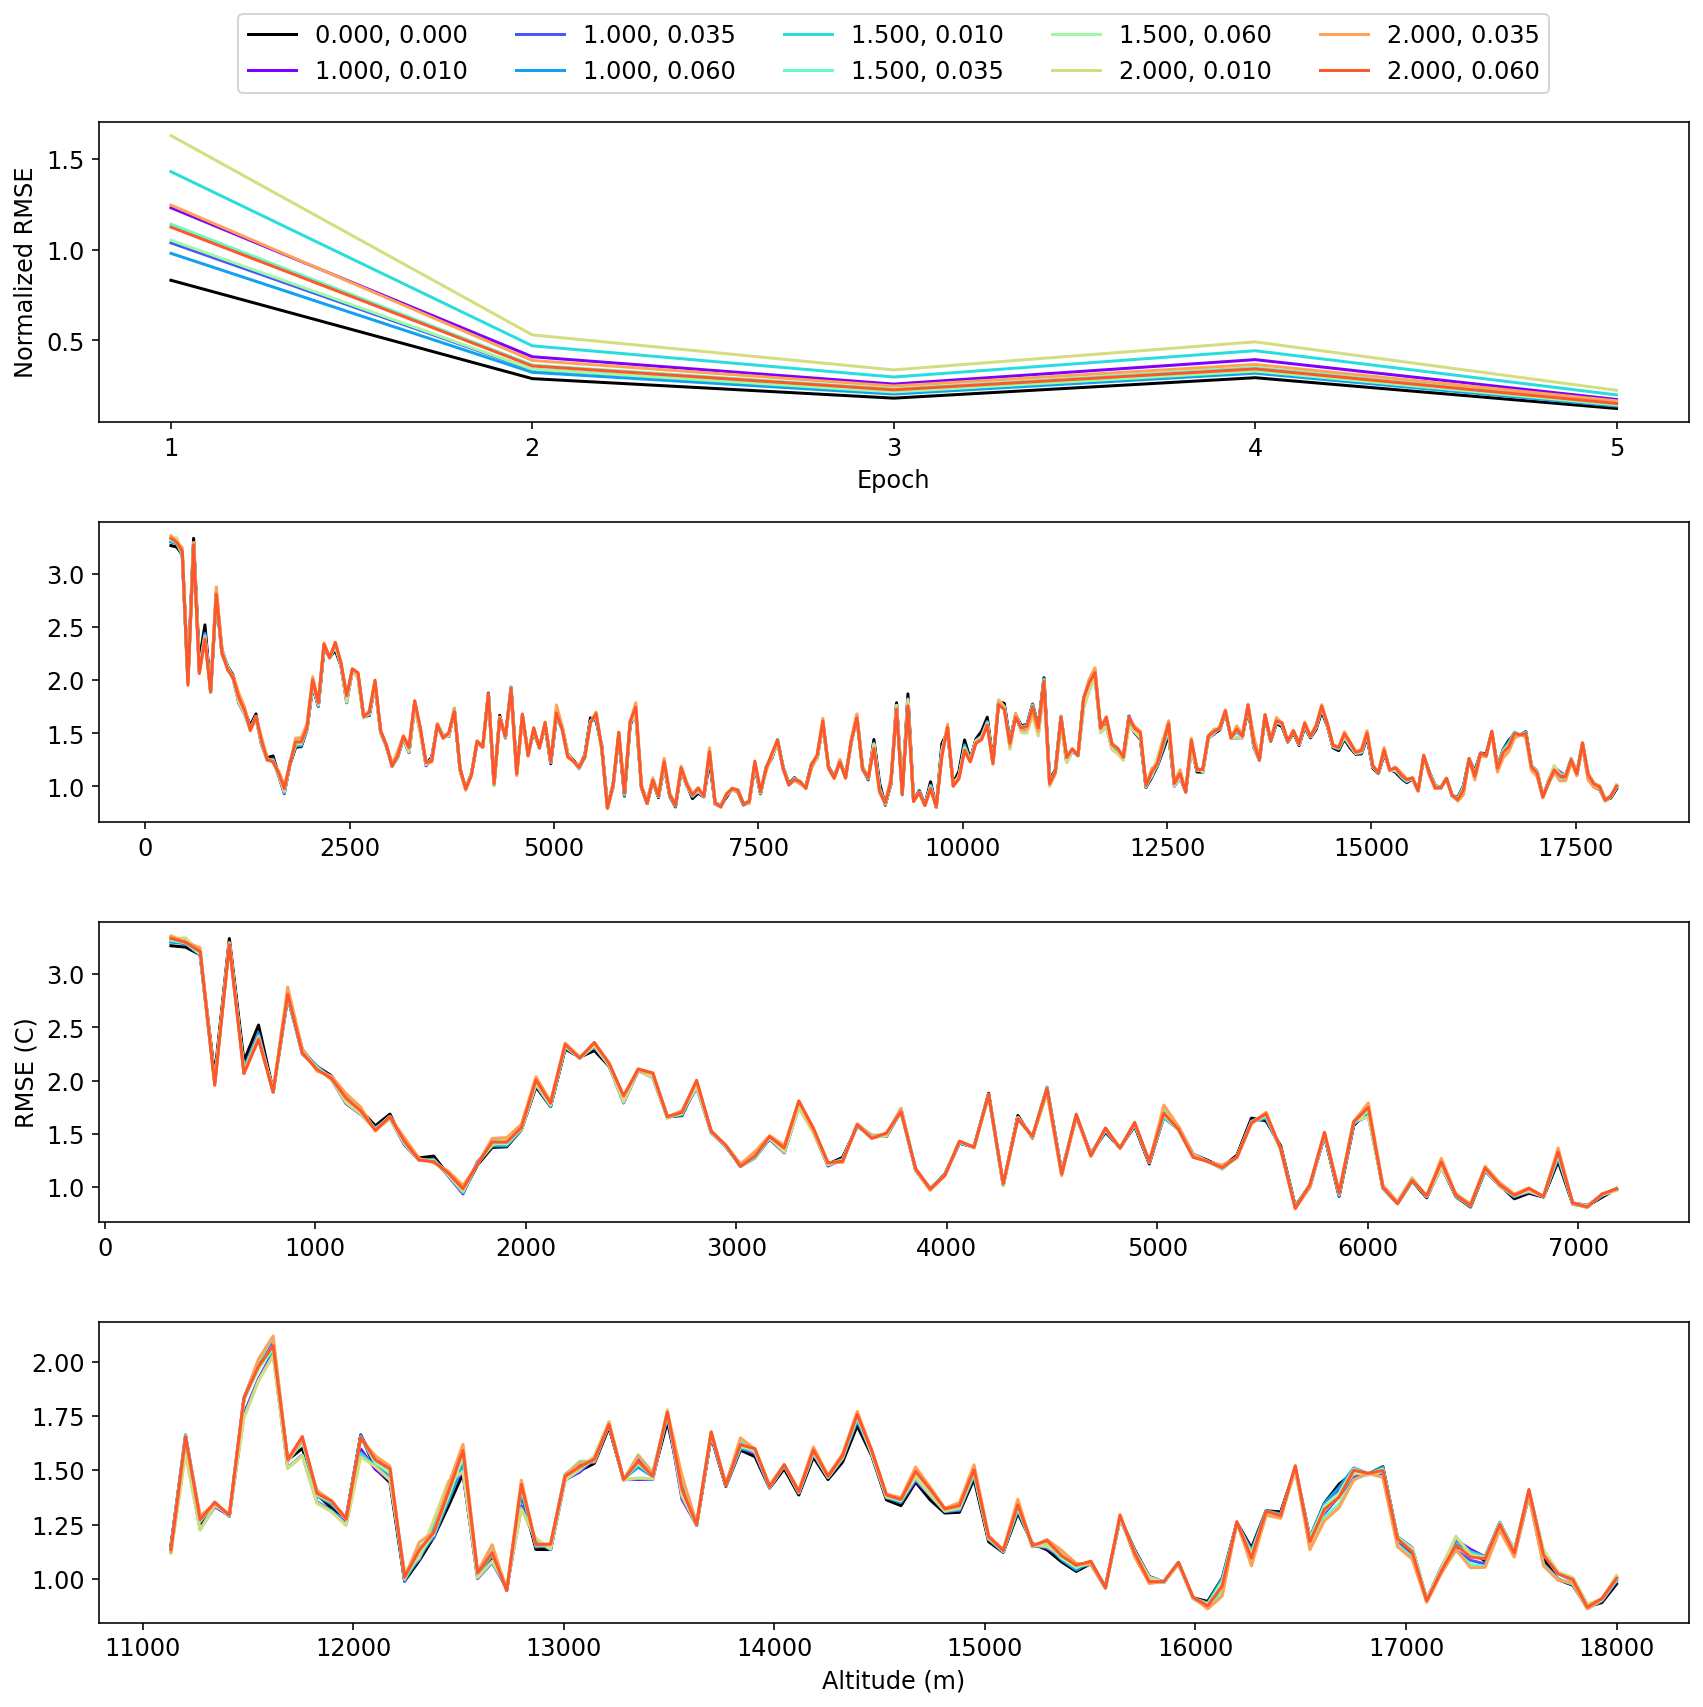

In [290]:
fig, axs = plt.subplots(4, 1, figsize=(12, 12))
axs = axs.ravel()

color=iter(plt.cm.rainbow(np.linspace(0,1,len(product))))
alt_s = raob[0, :, ALTITUDE][0]
altitude_intervals = np.linspace(alt_s, 18_000, 256)
altitude_window = 100

i = 0
for scale, lmda in product:
    c = next(color) if i > 0 else 'k'
    axs[0].plot(loss_l[i], label=f'{scale:.3f}, {lmda:.3f}', color=c)
    axs[1].plot(altitude_intervals, rmse_l[i], color=c)
    axs[2].plot(altitude_intervals[:altitude_window], rmse_l[i][:altitude_window], color=c)
    axs[3].plot(altitude_intervals[-altitude_window:], rmse_l[i][-altitude_window:], color=c)
    i += 1

axs[0].set_xticks(range(len(loss_l[0])))
axs[0].set_xticklabels(range(1, len(loss_l[0]) + 1))
axs[0].set_xlabel('Epoch'); axs[0].set_ylabel('Normalized RMSE')
axs[3].set_xlabel('Altitude (m)'); axs[2].set_ylabel('RMSE (C)');

axs.flatten()[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=5)
fig.tight_layout();

# RAP + GOES

In [6]:
def parition(rap=None, raob=None, goes=None, rtma=None, 
             percentages=(0.8,0.2), shuffle=True):
    
    trainFraction, testFraction = percentages
    n = raob.shape[0]
    nTrain = round(trainFraction * n)
    nTest = round(testFraction * n)
    rowIndices = np.arange(n)
    if shuffle:
        np.random.shuffle(rowIndices)
        
    RAPtrain = rap[rowIndices[:nTrain], :] if rap is not None else None
    RAOBtrain = raob[rowIndices[:nTrain], :] if raob is not None else None
    GOEStrain = goes[rowIndices[:nTrain], :] if goes is not None else None
    RTMAtrain = rtma[rowIndices[:nTrain], :] if rtma is not None else None
    
    RAPtest = rap[rowIndices[nTrain:nTrain+nTest], :] if rap is not None else None
    RAOBtest = raob[rowIndices[nTrain:nTrain+nTest], :] if raob is not None else None
    GOEStest = goes[rowIndices[nTrain:nTrain+nTest], :] if goes is not None else None
    RTMAtest = rtma[rowIndices[nTrain:nTrain+nTest], :] if rtma is not None else None
    
    return (RAPtrain, RAOBtrain, GOEStrain, RTMAtrain,
            RAPtest, RAOBtest, GOEStest, RTMAtest)

In [7]:
RAPtrain, RAOBtrain, GOEStrain, _, RAPtest, RAOBtest, GOEStest, _ = parition(rap, raob, goes)

input_dims = [PRESSURE, TEMPERATURE]

RAPtrain = RAPtrain[:, :, input_dims]
RAOBtrain = RAOBtrain[:, :, TEMPERATURE]

RAPtest = RAPtest[:, :, input_dims]
RAOBtest = RAOBtest[:, :, TEMPERATURE]

# GOEStrain = GOEStrain[:, :, :, 0:1]
# GOEStest = GOEStest[:, :, :, 0:1]

RAPtrain.shape, RAOBtrain.shape, GOEStrain.shape, RAPtest.shape, RAOBtest.shape, GOEStest.shape

((114, 256, 2),
 (114, 256),
 (114, 28, 28, 8),
 (28, 256, 2),
 (28, 256),
 (28, 28, 28, 8))

In [31]:
n_goes_inputs = GOEStrain.shape[1:]
n_rap_inputs = RAPtrain.shape[1:]
n_outputs = RAOBtrain.shape[1]

nnet = goesnn.GOESNeuralNetwork(n_goes_inputs, n_rap_inputs, n_outputs, seed=1234)
nnet.train(GOEStrain, RAPtrain, RAOBtrain, 50, 32, method='adam',
           verbose=True, learning_rate=0.001)

epoch: 0, loss: 1815.71411
epoch: 5, loss: 1729.01099
epoch: 10, loss: 1576.88159
epoch: 15, loss: 1406.48743
epoch: 20, loss: 1247.71887
epoch: 25, loss: 1101.01880
epoch: 30, loss: 967.10651
epoch: 35, loss: 844.41370
epoch: 40, loss: 735.27563
epoch: 45, loss: 636.29395
epoch: 49, loss: 566.39386
finished!


GOESNeuralNetwork(256)
  Final objective value is 566.39386 in 1.9992 seconds.

In [32]:
nnet.model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
goes (InputLayer)               [(None, 28, 28, 8)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 10)   730         goes[0][0]                       
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 14, 14, 10)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 10)   910         max_pooling2d[0][0]              
_______________________________________________________________________________________

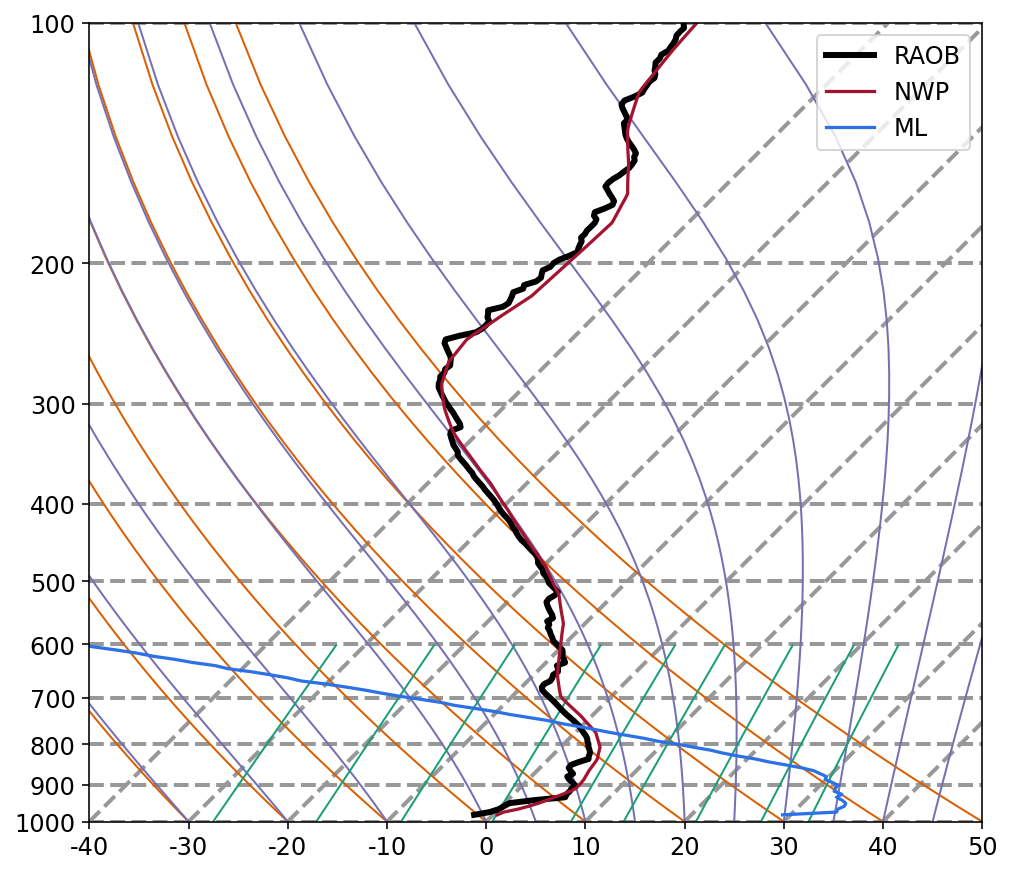

In [33]:
i = 0
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = RAPtrain[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = RAOBtrain[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = RAPtrain[i,:,TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(GOEStrain[i:i+1],RAPtrain[i:i+1])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

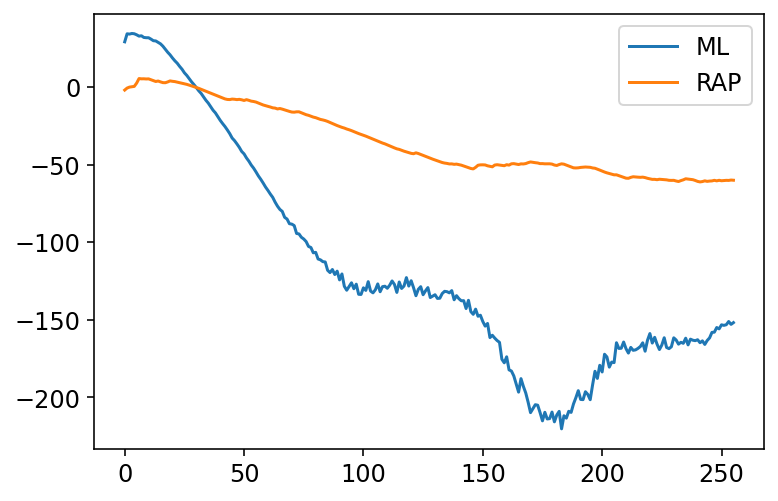

In [34]:
plt.plot(nnet.use(GOEStrain[i:i+1], RAPtrain[i:i+1])[0], label='ML')
plt.plot(RAOBtrain[i], label='RAP')
plt.legend();

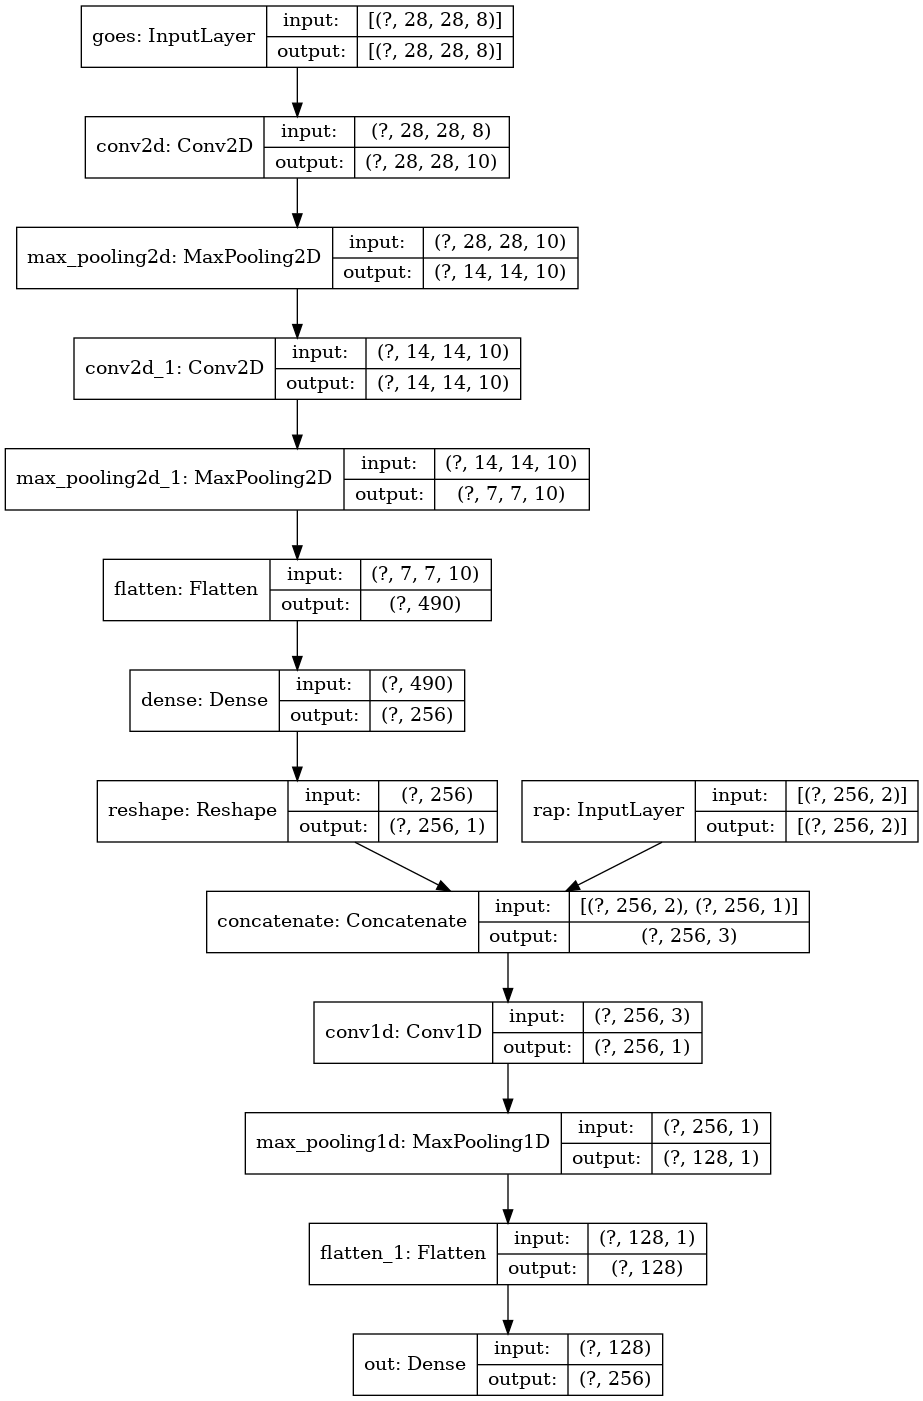

In [35]:
tf.keras.utils.plot_model(nnet.model, '/home/stock/research/media/multi_input_and_output_model.png',
                          show_shapes=True, rankdir='TB', dpi=96) # LR/TB positioning

In [26]:
interm = tf.keras.Model(nnet.model.inputs,nnet.model.get_layer('concatenate').output)
def iterm_predict(goes, rap):
    goes = nnet._standardizeGOES(goes)
    rap  = nnet._standardizeRAP(rap)
    return interm.predict({'goes': goes, 'rap': rap})

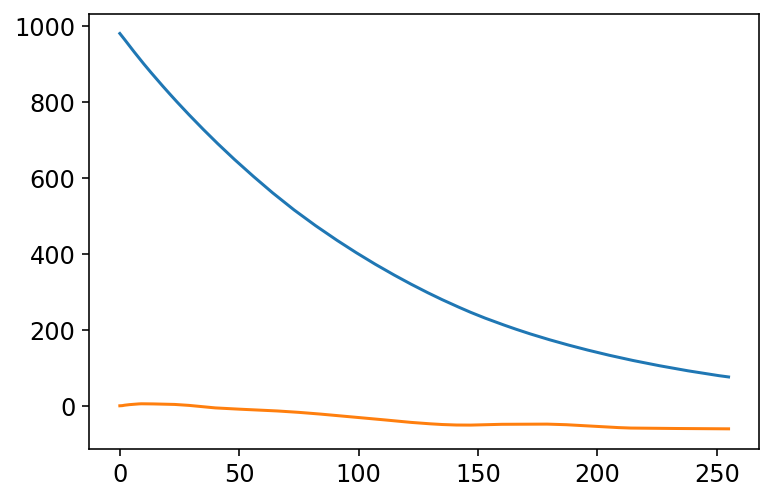

In [27]:
i = 0
plt.plot(RAPtrain[i,:, 0], label='pressure')
plt.plot(RAPtrain[i,:, 1], label='temperature');

In [28]:
a = nnet._standardizeRAP(RAPtrain)

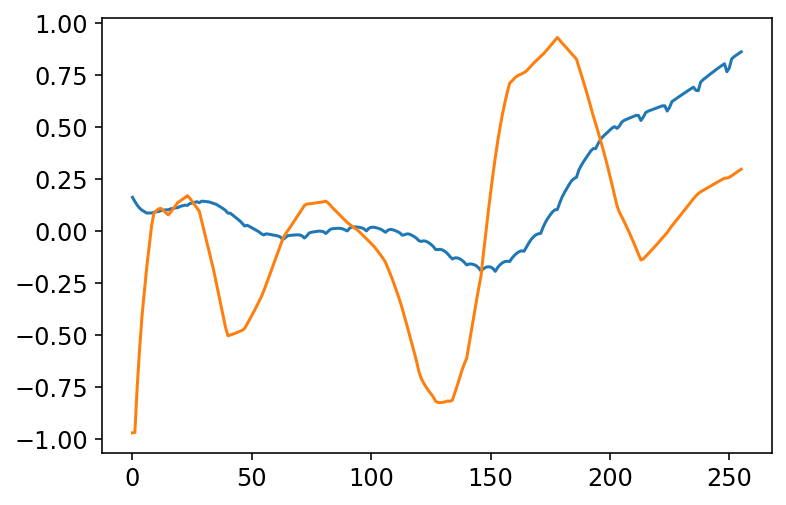

In [29]:
plt.plot(a[i,:, 0], label='pressure')
plt.plot(a[i,:, 1], label='temperature');

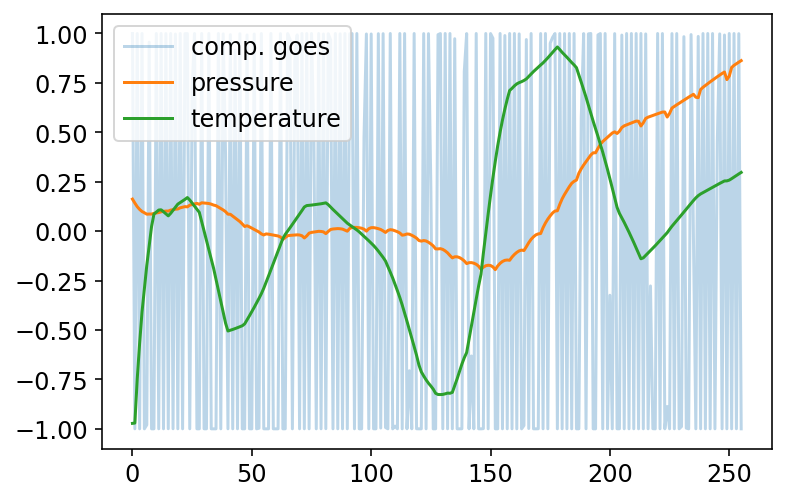

In [30]:
i = 0
Y = iterm_predict(GOEStrain[i:i+1], RAPtrain[i:i+1])

plt.plot(Y[0,:,2], alpha=0.3, label='comp. goes')
plt.plot(Y[0,:,0], label='pressure')
plt.plot(Y[0,:,1], label='temperature')

plt.legend();

# RAP + RTMA

# RAP + GOES + RTMA